<h1><center>Potato Disease classification:Application of CNN</center></h1>

## Problem statement

The dataset consists of 3 classes of potato leaves.The three clasees are Healthy,Early blight and Late blight.
Among these healthy leaves are the one with no disease and other two being the major diseases for potato plant.
Now,we build a model which takes a leaf as an input and classifies the leaf is healthy or not.If not what kind of disease it has.

<h3><center>Healthy leaf</center></h3>


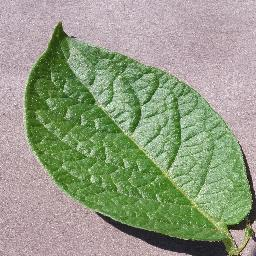

<h3><center>Early blight</center></h3>

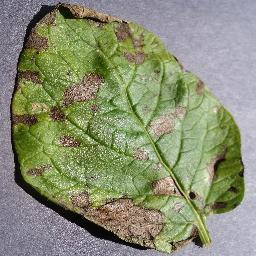

<h3><center>Late blight</center></h3>

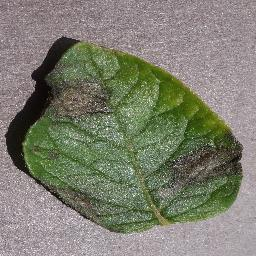


**Data set can be found from Kaggle**:https://www.kaggle.com/arjuntejaswi/plant-village

### Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

#### Intialising some important variables

In [1]:
BATCH_SIZE = 32 #Takes this amount of number data at  once
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50 #This is number of iterations through which Neural netwrok is trained

### Importing Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


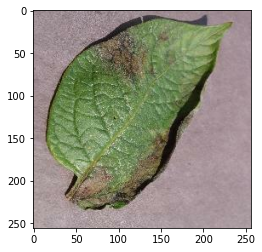

In [7]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

### Visualising the class of data

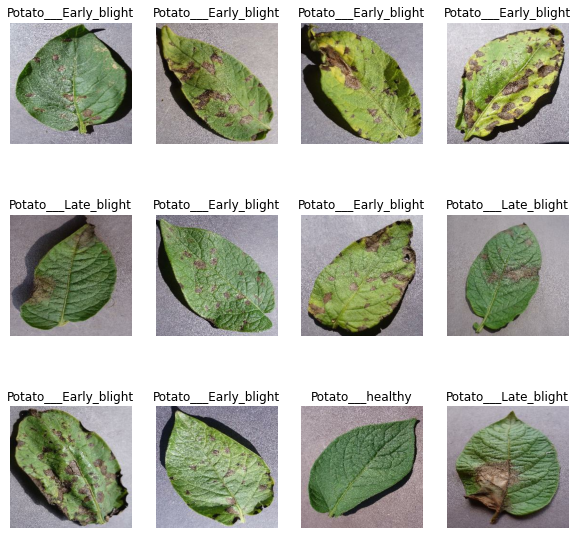

In [8]:
 plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Splitting the  Dataset into Train,Validation and test data sets

In [9]:
len(dataset)

68

The number 68 represents the total amount of data is drawn with a size of 32.
68*32 = 2176.But Mmaximum data points is 2152.So length of datset is 68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Putting all these train split commands into a single function....

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the model

### Creating a layer for Resizing and normalisation

Instead of directly feeding images into network,it is always prefered to do the resizing and rescaling.Although we have already imported the images with required size for future applications we use resizing.

And Rescaling is simply normalsising to get the all pixel values in the range of (0,1) by dividing each pixel value by 255.

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

Data augmentation is a method of more training data with the use of existing data.In this the same image can be flipped ,rotated and the new fliiped and rotated images can also be used as training data.The more available train data can improve accuracy.

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data augmentation to the training set

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    #The patrameter 32 is the number of layers that is number of different features thata are applied.
    #The second parameter i.e, kernel_size is actual filter size(3*3) that feature goes through.
    layers.MaxPooling2D((2, 2)), 
    #MAX pooling is done with a fliter window of 2*2
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    #The n_classes parameter the determines the number of nodes in the output layer.So here we are classsifying 3 classes so the n_classes=3
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the model

Here we use **adam** optimizer and **SparseCategoricalCrossentropy** for losses and **accuracy** as metric

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 113s 2s/step - loss: 0.8993 - accuracy: 0.5023 - val_loss: 0.8136 - val_accuracy: 0.7396
Epoch 2/50
54/54 [==============================] - 118s 2s/step - loss: 0.6454 - accuracy: 0.7240 - val_loss: 0.4278 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 101s 2s/step - loss: 0.3607 - accuracy: 0.8582 - val_loss: 0.3410 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 93s 2s/step - loss: 0.3026 - accuracy: 0.8872 - val_loss: 0.2296 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 89s 2s/step - loss: 0.2672 - accuracy: 0.8964 - val_loss: 0.2250 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 88s 2s/step - loss: 0.2204 - accuracy: 0.9138 - val_loss: 0.1910 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 90s 2s/step - loss: 0.1981 - accuracy: 0.9277 - val_loss: 0.1626 - val_accuracy: 0.9427
Epoch 8/50
54/54 

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 342ms/step - loss: 0.0420 - accuracy: 0.9844


In [27]:
scores

[0.04201868921518326, 0.984375]

### Plotting the accuracy and loss curves

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['loss'][:5]

[0.899285078048706,
 0.6454268097877502,
 0.3607354760169983,
 0.30263927578926086,
 0.2671973407268524]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

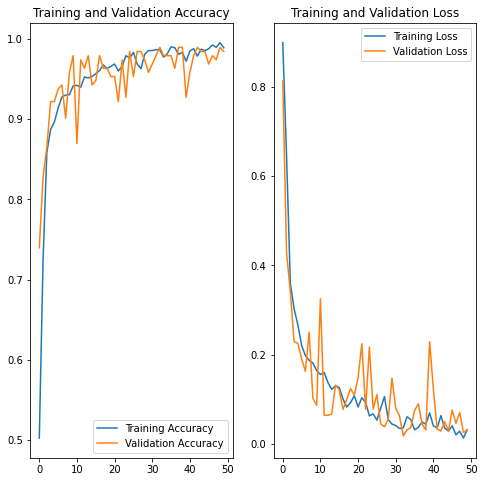

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model is about 98-99 percent accurate which is very good.

#### To know more about, use these following resourses.

1.Convolution Neural Network:https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

2.Actavation functions : https://towardsdatascience.com/everything-you-need-to-know-about-activation-functions-in-deep-learning-models-84ba9f82c253

3.Softmax actvation function :https://machinelearningmastery.com/softmax-activation-function-with-python/

4.Documentation on history object :https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

#### Source of project:https://www.youtube.com/watch?v=dGtDTjYs3xc&list=PLeo1K3hjS3ut49PskOfLnE6WUoOp_2lsD&index=1